# Data Loader

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [7]:
import os
from os.path import exists
import cv2

class CustomGen(keras.utils.Sequence):

    def __init__(self, img_path, img_path_mask, batch_size):
        self.img_path = img_path
        self.img_path_mask = img_path_mask
        self.batch_size = batch_size
        self.list_elements = os.listdir(self.img_path)
        self.list_elements_mask = os.listdir(self.img_path_mask)

    def __len__(self):
#         self.list_elements = os.listdir(self.img_path)
#         self.list_elements_mask = os.listdir(self.img_path_mask)
        return len(self.list_elements) // self.batch_size

    def __getitem__(self,idx):        
        X_paths = self.list_elements[idx*self.batch_size:(idx+1)*self.batch_size]
        y_paths = self.list_elements_mask[idx*self.batch_size:(idx+1)*self.batch_size]

        X = []
        y = []

        for x_filename in X_paths:
            X.append(load_img(self.img_path + x_filename))
            y_filename = x_filename.replace('.jpg','_mask.jpg')
            y_path = self.img_path_mask + y_filename
            file_exists = exists(y_path)
            if file_exists:
                # y.append(load_img('../data/Oil Tanks/image_patches/'+x_filename))
                temp_y = np.array(load_img(y_path))[:, :, 0:1]
                y.append(temp_y)
            else:
#                 import ipdb; ipdb.set_trace()
                img = cv2.imread(self.img_path + x_filename)
                black_img = (img*0)[:, :, 0:1]
                y.append(black_img)

        return np.stack(X)/255., np.stack(y)/255.

In [41]:
batch_size = 8

In [45]:
img_path_mask

'../data/case1_tanks/output_maskimage_patches_mask/'

In [44]:
data_loader.__init__(img_path, img_path_mask, batch_size)

FileNotFoundError: [Errno 2] No such file or directory: '../data/case1_tanks/output_maskimage_patches_mask/'

In [8]:
!pwd

/home/dushyant/code/dshekhawat-slb/oil-tanker-project/notebooks


In [43]:
path_data = '../data/Oil Tanks/'
img_path = path_data + 'image_patches/'
path_data = '../data/Oil Tanks/'
img_path_mask = path_data + 'image_patches_mask/'

In [10]:
data_loader = CustomGen(img_path, img_path_mask, 8)

In [11]:
len(data_loader)

1250

In [12]:
X,y = data_loader.__getitem__(42)

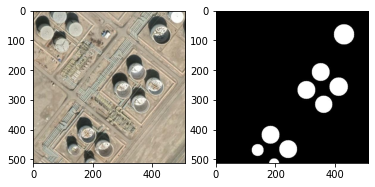

In [13]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(X[0])

plt.subplot(1,2,2)
plt.imshow(y[0], cmap ='gray')

In [14]:
X[0].shape, y[0].shape

((512, 512, 3), (512, 512, 1))

In [15]:
X.shape, y.shape

((8, 512, 512, 3), (8, 512, 512, 1))

### UNET Function

In [16]:
len(X)

8

In [17]:
from tensorflow.keras import layers, Model
from PIL import Image
import PIL 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [18]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape = img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [19]:
img_size = (512,512)
num_classes = 1

In [20]:
# Build model
model = get_model(img_size, num_classes)
model.summary()

2022-11-29 16:24:06.770232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dushyant/.pyenv/versions/3.8.12/envs/oil-tanker-project/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-29 16:24:06.770282: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 16:24:06.770307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SLB-G6MC3Z2): /proc/driver/nvidia/version does not exist
2022-11-29 16:24:06.770600: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
#Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(X, y,
          batch_size=2,
          epochs=10,
          validation_split=0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/10


2022-11-29 16:28:57.406009: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 402653184 exceeds 10% of free system memory.
2022-11-29 16:31:01.298221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 402653184 exceeds 10% of free system memory.


1/1 [==============================] - 460s 460s/step - loss: 2.7614 - accuracy: 0.4544 - val_loss: 0.2407 - val_accuracy: 1.0000
Epoch 2/10


2022-11-29 16:32:03.202316: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 402653184 exceeds 10% of free system memory.


1/1 [==============================] - 5s 5s/step - loss: 7.0847 - accuracy: 0.6454 - val_loss: 0.5744 - val_accuracy: 0.9436
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.3303 - accuracy: 0.9838 - val_loss: 0.5934 - val_accuracy: 0.9644
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.3601 - accuracy: 0.9838 - val_loss: 0.4198 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.3801 - accuracy: 0.9838 - val_loss: 0.2787 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.3607 - accuracy: 0.9838 - val_loss: 0.1853 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 10s 10s/step - loss: 0.3043 - accuracy: 0.9838 - val_loss: 0.1177 - val_accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 9s 9s/step - loss: 0.2199 - accuracy: 0.9838 - val_loss: 0.0639 - val_accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 

In [24]:
history.history

{'loss': [2.761357307434082,
  7.084657192230225,
  0.33025118708610535,
  0.3601430356502533,
  0.38009557127952576,
  0.36070653796195984,
  0.304321825504303,
  0.21991103887557983,
  0.11544745415449142,
  0.053431954234838486],
 'accuracy': [0.45444998145103455,
  0.6454188227653503,
  0.9837570190429688,
  0.9837837219238281,
  0.9837837219238281,
  0.9837837219238281,
  0.9837837219238281,
  0.9837837219238281,
  0.9850654602050781,
  0.9843661189079285],
 'val_loss': [0.24069836735725403,
  0.5744438767433167,
  0.5933594107627869,
  0.4198058247566223,
  0.2787473201751709,
  0.1853450983762741,
  0.11769746989011765,
  0.06388279795646667,
  0.026898255571722984,
  0.009292848408222198],
 'val_accuracy': [1.0,
  0.9436168670654297,
  0.9644145965576172,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

In [ ]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(data_loader,
          epochs=10,
          validation_data = data_loader_val,
          callbacks=[es],
          verbose=1)



### image resize in-progress

In [25]:
from tensorflow.image import resize

In [26]:
#Test data prep

image_temp = cv2.imread('../data/Oil Tanks/image_patches/01_0_0.jpg')
image_temp2 =  cv2.imread('../data/Oil Tanks/image_patches/01_0_1.jpg')

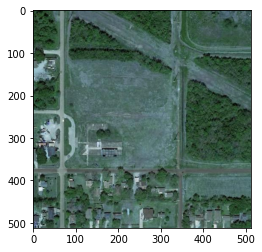

In [27]:
plt.imshow(image_temp)

In [28]:
image_temp.shape

(512, 512, 3)

In [30]:
image_temp_resized = resize(
    image_temp,
    [256,256],
    preserve_aspect_ratio=True,
    antialias=False,
    name=None
)

In [31]:
image_temp_resized.shape

TensorShape([256, 256, 3])

In [ ]:
image_temp_resized

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


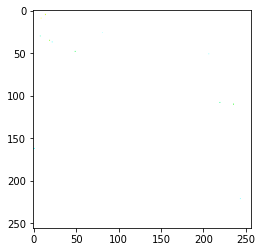

In [32]:
plt.imshow(image_temp_resized)